In [1]:
import pandas as pd
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
import difflib
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.manifold import TSNE
import plotly.express as px
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict
import os
from os import getenv

In [2]:
df = pd.read_csv('../data/data.csv')
data_artist_df = pd.read_csv('../data/data_by_artist.csv')
data_genre_df = pd.read_csv('../data/data_by_genres.csv')
data_year_df = pd.read_csv('../data/data_by_year.csv')
data_w_genre_df = pd.read_csv('../data/data_w_genres.csv')

In [3]:
df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


In [4]:
data_artist_df.shape

(32539, 15)

In [5]:
df['artists'] = df['artists'].str.strip('[]')

In [6]:
df['artists'] = df['artists'].str.strip('"')

In [7]:
df['artists'] = df['artists'].str.strip("'")

In [8]:
df["artists"]

0                            Mamie Smith
1                  Screamin' Jay Hawkins
2                            Mamie Smith
3                        Oscar Velazquez
4                                   Mixe
                       ...              
174384    DJ Combo', 'Sander-7', 'Tony T
174385                      Alessia Cara
174386                         Roger Fly
174387                      Taylor Swift
174388                         Roger Fly
Name: artists, Length: 174389, dtype: object

In [9]:
df = df.drop(columns='release_date')
df = df.drop(columns='year')


In [10]:
df.head()
path = r'C:/Users/Megal/OneDrive/Documents/Github/build week spotify/ds-modeling/spotify_df.csv'

In [11]:
df.to_csv(path_or_buf=path)

In [12]:
number_cols = ['acousticness', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
               'popularity', 'speechiness', 'tempo', 'valence'] # year

In [13]:

cluster_pipeline = Pipeline([('scaler', StandardScaler()),('kmeans',
                                                           KMeans(n_clusters=10, n_jobs=-1))])
X = data_genre_df.select_dtypes(np.number)
cluster_pipeline.fit(X)
data_genre_df['cluster'] = cluster_pipeline.predict(X)

In [14]:

tsne_pipeline = Pipeline([('scaler', StandardScaler()), ('tsne', TSNE(n_components=2, verbose=2))])

genre_embedding = tsne_pipeline.fit_transform(X)

projection = pd.DataFrame(columns=['x', 'y'], data=genre_embedding)
projection['genres'] = data_genre_df['genres']
projection['cluster'] = data_genre_df['cluster']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'genres'])
fig.show()


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3232 samples in 0.022s...
[t-SNE] Computed neighbors for 3232 samples in 0.764s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3232
[t-SNE] Computed conditional probabilities for sample 2000 / 3232
[t-SNE] Computed conditional probabilities for sample 3000 / 3232
[t-SNE] Computed conditional probabilities for sample 3232 / 3232
[t-SNE] Mean sigma: 0.789973
[t-SNE] Computed conditional probabilities in 0.189s
[t-SNE] Iteration 50: error = 82.8492813, gradient norm = 0.0297146 (50 iterations in 2.576s)
[t-SNE] Iteration 100: error = 77.7379074, gradient norm = 0.0149348 (50 iterations in 1.932s)
[t-SNE] Iteration 150: error = 76.6442795, gradient norm = 0.0183082 (50 iterations in 1.712s)
[t-SNE] Iteration 200: error = 76.2951202, gradient norm = 0.0058751 (50 iterations in 1.569s)
[t-SNE] Iteration 250: error = 76.2184753, gradient norm = 0.0023559 (50 iterations in 1.364s)
[t-SNE] KL divergence after 250 iterati

In [15]:
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()),
                                  ('kmeans', KMeans(n_clusters=20,
                                                    verbose=2, n_jobs=-1))], verbose=True)
X = df.select_dtypes(np.number)
number_cols = list(X.columns)
song_cluster_fitted = song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)
df['cluster_label'] = song_cluster_labels

1, inertia 1046846.357476191
Iteration 22, inertia 1046820.2064556519
Iteration 23, inertia 1046804.2827641711
Iteration 24, inertia 1046794.5313635863
Iteration 25, inertia 1046789.2167879049
Iteration 26, inertia 1046786.1450824946
Converged at iteration 26: center shift 7.797439737144258e-05 within tolerance 9.999999999999879e-05.
Initialization complete
Iteration 0, inertia 1504205.461564059
Iteration 1, inertia 1127234.6312071322
Iteration 2, inertia 1092846.8541427704
Iteration 3, inertia 1078344.0487455432
Iteration 4, inertia 1070953.1350223029
Iteration 5, inertia 1066843.3874103578
Iteration 6, inertia 1064354.063430977
Iteration 7, inertia 1062890.4264164658
Iteration 8, inertia 1061854.0745945727
Iteration 9, inertia 1061097.049567107
Iteration 10, inertia 1060486.7891881175
Iteration 11, inertia 1059916.5099633383
Iteration 12, inertia 1059215.8179936903
Iteration 13, inertia 1057930.532513715
Iteration 14, inertia 1052800.6619332207
Iteration 15, inertia 1040348.033219864

In [16]:
import pickle
cluster_file = 'cluster.pickle'
pickle.dump(song_cluster_pipeline, open(cluster_file, 'wb'))

In [17]:


SPOTIPY_CLIENT_ID = getenv('SPOTIPY_CLIENT_ID')
SPOTIPY_SECRET_ID = getenv('SECRET_ID')

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=SPOTIPY_CLIENT_ID,
                                                           client_secret=SPOTIPY_SECRET_ID))

def find_song(name):
  song_data = defaultdict()
  results = sp.search(q='track: {}'.format(name), limit=1)
  if results['tracks']['items'] == []:
    return None

  results = results['tracks']['items'][0]
  track_id = results['id']
  audio_features = sp.audio_features(track_id)[0]

  song_data['name'] = [name]  
  # song_data['year'] = [year]
  song_data['explicit'] = [int(results['explicit'])]
  song_data['duration_ms'] = [results['duration_ms']]
  song_data['popularity'] = [results['popularity']]

  for key, value in audio_features.items():
    song_data[key] = value

  return pd.DataFrame(song_data)

In [18]:
xd = sp.search(q="track: michael jackson")

In [19]:
xd = xd['tracks']['items'][0]

In [20]:
t_id = xd['id']

In [21]:
find_song("Thriller")

,name,explicit,duration_ms,popularity,danceability,energy,key,loudness,mode,speechiness,...,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,time_signature
0,Thriller,0,358053,67,0.764,0.887,11,-3.726,1,0.0744,...,0.00011,0.847,0.72,118.427,audio_features,7azo4rpSUh8nXgtonC6Pkq,spotify:track:7azo4rpSUh8nXgtonC6Pkq,https://api.spotify.com/v1/tracks/7azo4rpSUh8n...,https://api.spotify.com/v1/audio-analysis/7azo...,4


In [22]:
audio_feat = sp.audio_features(t_id)[0]

In [23]:
audio_feat

{'danceability': 0.822,
 'energy': 0.318,
 'key': 10,
 'loudness': -12.391,
 'mode': 1,
 'speechiness': 0.0575,
 'acousticness': 0.493,
 'instrumentalness': 0.0128,
 'liveness': 0.11,
 'valence': 0.138,
 'tempo': 102.998,
 'type': 'audio_features',
 'id': '6G8kHiVZ1jW7vHMPVRNZU0',
 'uri': 'spotify:track:6G8kHiVZ1jW7vHMPVRNZU0',
 'track_href': 'https://api.spotify.com/v1/tracks/6G8kHiVZ1jW7vHMPVRNZU0',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/6G8kHiVZ1jW7vHMPVRNZU0',
 'duration_ms': 245787,
 'time_signature': 4}

In [24]:
def get_song_data(song, df):

  try:
    song_data = df[(df['name'] == song['name'])].iloc[0]
     
    return song_data
  
  except IndexError:
    return find_song(song['name']) # , song['year']


def get_mean_vector(song_list, df):
  
  song_vectors = []

  for song in song_list:
    song_data = get_song_data(song, df)
    if song_data is None:
      print('Warning: {} does not exist in Spotify or in database'.format(song['name']))
      continue
    song_vector = song_data[number_cols].values
    song_vectors.append(song_vector)

  song_matrix = np.array(list(song_vectors))
  return np.mean(song_matrix, axis=0)


def flatten_dict_list(dict_list):
  flattened_dict = defaultdict()
  for key in dict_list[0].keys():
    flattened_dict[key] = []
  
  for dictionary in dict_list:
    for key, value in dictionary.items():
      flattened_dict[key].append(value)
  return flattened_dict
  

def recommend_songs(song_list, df=df, n_songs=10):
  metadata_cols = ['name', 'artists']
  song_dict = flatten_dict_list(song_list)

  song_center = get_mean_vector(song_list, df)
  scaler = song_cluster_pipeline.steps[0][1]
  scaled_data = scaler.transform(df[number_cols])
  scaled_song_center = scaler.transform(song_center.reshape(1,-1))
  distances = cdist(scaled_song_center, scaled_data, 'cosine')
  index = list(np.argsort(distances)[:, :n_songs][0])

  rec_songs = df.iloc[index]
  rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])]
  ten_songs = rec_songs[metadata_cols].to_dict(orient='records')
  return ten_songs, scaled_song_center, scaled_data

In [25]:
ten_song, ssc, sd = recommend_songs([{'name': 'DVP'}])

In [26]:
ten_song

[{'name': 'Tired Of Sex', 'artists': 'Weezer'},
 {'name': 'How You Love Me Now', 'artists': 'Hey Monday'},
 {'name': 'Heaven Is Falling', 'artists': 'Bad Religion'},
 {'name': 'Lost in Space', 'artists': 'Misfits'},
 {'name': "You Be Tails, I'll Be Sonic", 'artists': 'A Day To Remember'},
 {'name': 'Drowning (Face Down)', 'artists': 'Saving Abel'},
 {'name': 'Angels Of The Silences', 'artists': 'Counting Crows'},
 {'name': 'Anarchy in the U.K.', 'artists': 'Sex Pistols'},
 {'name': 'Search and Destroy - Iggy Pop Mix', 'artists': 'The Stooges'},
 {'name': 'The Air That I Breathe', 'artists': 'All That Remains'}]

In [27]:
sd[1]

array([ 0.37841108,  1.79089823, -0.55668873,  0.12570987, -0.27040128,
       -0.51065739, -0.05835388, -0.72148905,  0.78886167, -1.53623943,
       -0.85464531, -0.28711336, -0.99548519,  1.60871779])

In [28]:
r = ssc

In [29]:
r

array([[-1.3023512 , -0.99848224, -0.56549629,  1.88598466, -0.27040128,
        -0.5895536 ,  0.22587578,  0.6475452 ,  1.84937665,  0.6509402 ,
         1.15699688, -0.03417752,  1.02315088, -1.12498921]])

In [30]:
import itertools
r = list(itertools.chain.from_iterable(ssc))

In [31]:
r

[-1.3023512023072747,
 -0.9984822438640804,
 -0.5654962872405377,
 1.885984656756196,
 -0.2704012765337135,
 -0.5895536000587207,
 0.22587577760581226,
 0.647545196258879,
 1.8493766514951722,
 0.6509401971195059,
 1.1569968768721903,
 -0.034177522490510294,
 1.0231508827755875,
 -1.1249892086132696]

In [32]:
df1 = pd.DataFrame(dict(r=[r], theta=[number_cols]))

In [33]:
df1

,r,theta
0,"[-1.3023512023072747, -0.9984822438640804, -0....","[acousticness, danceability, duration_ms, ener..."


In [34]:
user_input = input('enter a song, or artist and well suggest 10 new songs:')
input_dict = {'name': user_input[0]}
recommend_songs([input_dict])

([{'name': 'drivers license', 'artists': 'Olivia Rodrigo'},
  {'name': 'Moral of the Story', 'artists': 'Ashe'},
  {'name': 'Nikes', 'artists': 'Frank Ocean'},
  {'name': 'happiness', 'artists': 'Taylor Swift'},
  {'name': 'Moral of the Story (feat. Niall Horan)',
   'artists': "Ashe', 'Niall Horan"},
  {'name': 'Training Wheels', 'artists': 'Melanie Martinez'},
  {'name': 'Be Alright', 'artists': 'Dean Lewis'},
  {'name': 'gold rush', 'artists': 'Taylor Swift'},
  {'name': 'Better Now', 'artists': 'Post Malone'},
  {'name': 'Candy', 'artists': 'Doja Cat'}],
 array([[ 0.58370948,  0.27406608,  0.06202328, -0.17133651,  3.69820739,
         -0.58952485,  1.3627944 , -0.58796528,  0.52531422,  0.6509402 ,
          3.39723477, -0.25035262,  0.88806172, -1.48418999]]),
 array([[ 1.29435782,  0.34791933, -0.4344949 , ..., -0.06654892,
          1.08975345,  0.41390256],
        [ 0.37841108,  1.79089823, -0.55668873, ..., -0.28711336,
         -0.99548519,  1.60871779],
        [ 1.2996218

In [35]:
b = list(itertools.chain.from_iterable(ssc))

In [36]:
b[1].dtype

dtype('float64')

In [37]:
import plotly.graph_objects as go 

categories = number_cols

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
    r=r,
    theta = categories,
    fill='toself',
    name='dvp'
))
fig.add_trace(go.Scatterpolar(
    r=r1,
    theta = categories,
    fill='toself',
    name=ten_song[5]['name']

))
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 2]
        )),
    showlegend=True
)
fig.show()

NameError: name 'r1' is not defined

In [ ]:
fig = px.bar(df1, x=r, y=number_cols , orientation='h')

fig.show()

In [ ]:
df2 = pd.DataFrame(dict(r=sd[1], theta=number_cols))

In [ ]:
fig2 = px.bar(df2, x=sd[1], y=number_cols, orientation='h' )
fig2.show()

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
def graph_against(input, n):
    input_dict = {'name': str(input)}
    ten_song, ssc, sd = recommend_songs([input_dict])

    r = list(itertools.chain.from_iterable(ssc))

    df = pd.DataFrame(dict(graph=number_cols, input=r, output=sd[n]))

    ind = np.arange(len(df))
    width = 0.4

    fig, ax = plt.subplots()
    ax.barh(ind, df.input, width, color='red', label=str(song))
    ax.barh(ind + width, df.output, width, color='blue', label=ten_song[n]['name'])

    ax.set(yticks=ind + width, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
    ax.legend()

    return plt.show()

In [ ]:
graph_against('country roads', n=5)


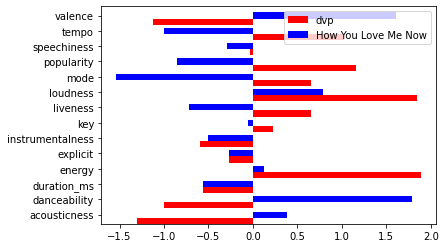

In [47]:

df = pd.DataFrame(dict(graph=number_cols, input=r, output=sd[1]))

ind = np.arange(len(df))
width = 0.4

fig, ax = plt.subplots()
ax.barh(ind, df.input, width, color='red', label='dvp')
ax.barh(ind + width, df.output, width, color='blue', label=ten_song[1]['name'])
ax.set(yticks=ind + width, yticklabels=df.graph, ylim=[2*width - 1, len(df)])
ax.legend()
plt.show()

In [54]:
trace1 = go.bar(x=df.input, y=df.graph , orientation='h')

TypeError: 'module' object is not callable

In [62]:
def plot_plotly(input, n):
    input_dict = {'name': str(input)}
    ten_song, ssc, sd = recommend_songs([input_dict])
    n = n-1

    r = list(itertools.chain.from_iterable(ssc))

    df = pd.DataFrame(dict(graph=number_cols, input=r, output=sd[n]))


    fig = go.Figure(
        data=[
            go.Bar(name=str(input), x=df.input, y=df.graph, orientation='h'),
            go.Bar(name=ten_song[n]['name'], x=df.output, y=df.graph, orientation='h')
        ],
        layout = { 'yaxis': {'title':'spotify metrics'}}
    )
    fig.update_layout(barmode='group')

    return fig.show()

In [64]:
plot_plotly('dvp', 3)